Generative model for next-layers prediction of entire PSC cell stack sequences

Preparing dataframe with desired features/layers

In [111]:
import pandas as pd

# Load the dataset
df = pd.read_csv(r'C:\Users\c\OneDrive\Documents\PEROVSKITE PROJECT\PerovskiteML_project\Data\Perovsite database query.csv')

# Strip whitespace from ALL string entries
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Remove rows with NaN values in key columns
df = df.dropna(subset=['Substrate_stack_sequence', 'ETL_stack_sequence', 'HTL_stack_sequence', 'Backcontact_stack_sequence', 'Perovskite_composition_long_form'])

# Define columns to keep
columns_to_keep = [
    'Cell_stack_sequence', 'Cell_architecture',
    'Substrate_stack_sequence',
    'ETL_stack_sequence', 'ETL_thickness', 'ETL_additives_compounds',
    'Perovskite_composition_a_ions', 'Perovskite_composition_a_ions_coefficients', 
    'Perovskite_composition_b_ions', 'Perovskite_composition_b_ions_coefficients',
    'Perovskite_composition_c_ions', 'Perovskite_composition_c_ions_coefficients', 
    'Perovskite_composition_short_form', 'Perovskite_composition_long_form', 'Perovskite_composition_leadfree', 'Perovskite_composition_inorganic',
    'Perovskite_additives_compounds', 'Perovskite_additives_concentrations', 'Perovskite_thickness', 'Perovskite_band_gap',
    'HTL_stack_sequence', 'HTL_thickness_list', 'HTL_additives_compounds',
    'Backcontact_stack_sequence',
    'Encapsulation', 'Encapsulation_stack_sequence', 'JV_default_PCE',
    'JV_default_Voc', 'JV_default_Jsc', 'JV_default_FF', 'JV_hysteresis_index', 'Stability_PCE_end_of_experiment'
]

# Keep only selected columns
df = df[columns_to_keep]

# Ensure all stack sequence columns are stripped of any extra spaces inside entries
for col in ['Substrate_stack_sequence', 'ETL_stack_sequence', 'HTL_stack_sequence', 'Backcontact_stack_sequence', 'Perovskite_composition_short_form']:
    df[col] = df[col].str.replace(r'\s*\|\s*', '|', regex=True)  # Remove spaces around '|'

# Now filter for common materials
df = df[
    df['Substrate_stack_sequence'].isin(['SLG|FTO', 'SLG|ITO']) &  
    df['ETL_stack_sequence'].isin(['TiO2-c|TiO2-mp', 'TiO2-c', 'PCBM-60|BCP', 'C60|BCP']) & 
    df['HTL_stack_sequence'].isin(['Spiro-MeOTAD', 'PEDOT:PSS']) &
    df['Backcontact_stack_sequence'].isin(['Au', 'Ag', 'Al', 'Carbon']) &
    df['Perovskite_composition_short_form'].isin(['MAPbI', 'CsFAMAPbBrI', 'FAMAPbBrI', 'CsPbBrI', 'MAPbBrI', 'FAPbI', 'CsFAPbBrI', 'CsPbBrI', 'CsPbI', 'CsFAPbI', 'MAPbBr']) &
    df['Cell_architecture'].isin(['nip'])       
]

# Classify perovskites into single-layered or multi-layered
ion_columns = [
    'Perovskite_composition_a_ions', 'Perovskite_composition_a_ions_coefficients', 
    'Perovskite_composition_b_ions', 'Perovskite_composition_b_ions_coefficients',
    'Perovskite_composition_c_ions', 'Perovskite_composition_c_ions_coefficients'
]

df['Layer Type'] = df.apply(
    lambda row: 'Multi-layered Perovskite' if any('|' in str(row[col]) for col in ion_columns) else 'Single-layered Perovskite',
    axis=1
)

# Keep only single-layered perovskites
filtered_df = df[df['Layer Type'] == 'Single-layered Perovskite']

# Create 'new cell stack' column by concatenating layers in the specified order
filtered_df['Cleaned cell stack'] = filtered_df['Substrate_stack_sequence'].astype(str) + ', ' + \
                       df['ETL_stack_sequence'].astype(str) + ', ' + \
                       df['Perovskite_composition_long_form'].astype(str) + ', ' + \
                       df['HTL_stack_sequence'].astype(str) + ', ' + \
                       df['Backcontact_stack_sequence'].astype(str)

filtered_df['Cleaned cell stack'] = filtered_df['Cleaned cell stack'].dropna().apply(lambda seq: f"<SOS>,{seq},<EOS>")

filtered_df['Perovskite_composition_long_form'] = filtered_df['Perovskite_composition_long_form'].str.strip()

# Save cleaned data
filtered_df.to_csv('cleaned_data_for_generative.csv', index=False)

C:\Users\c\AppData\Local\Temp\ipykernel_7964\612912116.py:4: DtypeWarning: Columns (10,22,29,31,32,35,36,40,44,45,46,48,51,54,65,84,89,90,93,98,99,100,105,108,115,118,122,123,125,130,134,138,142,143,144,146,149,152,163,166,167,171,172,173,175,178,181,192,194,225,271,272,273,277,304,315,321,325,330,331,335,336,342,348,369,371,373,374,376,380,384,387,403,405,407,409) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\c\OneDrive\Documents\PEROVSKITE PROJECT\PerovskiteML_project\Data\Perovsite database query.csv')
C:\Users\c\AppData\Local\Temp\ipykernel_7964\612912116.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


### Predicting PCE and stability from 'Full stack vectors'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
import pandas as pd
import ast
from sklearn.preprocessing import StandardScaler
import torch

# Load dataset
df = pd.read_csv(r'C:\Users\c\OneDrive\Documents\PEROVSKITE PROJECT\PerovskiteML_project\Generative model\cleaned_data_with_vectors.csv')  # Replace with actual dataset path

# Convert 'Full stack vectors' from string representation to list
df['Full stack vectors'] = df['Full stack vectors'].apply(ast.literal_eval)

# Drop rows with missing target variable 'JV_default_PCE'
df = df.dropna(subset=['JV_default_PCE'])

# Extract features (X) and target (Y)
X = np.array(df['Full stack vectors'].tolist(), dtype=np.float32)
Y = np.array(df['JV_default_PCE'].values, dtype=np.float32)

# Normalize perovskite composition (assuming it's from index 2 to 8)
scaler = StandardScaler()
X[:, 2:8] = scaler.fit_transform(X[:, 2:8])

# Scale the target variable 'Y'
Y = scaler.fit_transform(Y.reshape(-1, 1))  # Reshape Y to 2D before scaling

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32).view(-1, 1)  # Ensure Y is 2D with shape (n_samples, 1)

# Split into train and test sets
train_size = int(0.8 * len(X_tensor))
test_size = len(X_tensor) - train_size
train_dataset, test_dataset = random_split(TensorDataset(X_tensor, Y_tensor), [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define regression model
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model, loss, and optimizer
input_dim = X.shape[1]  # Assuming all vectors have the same length
model = RegressionModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_Y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}')

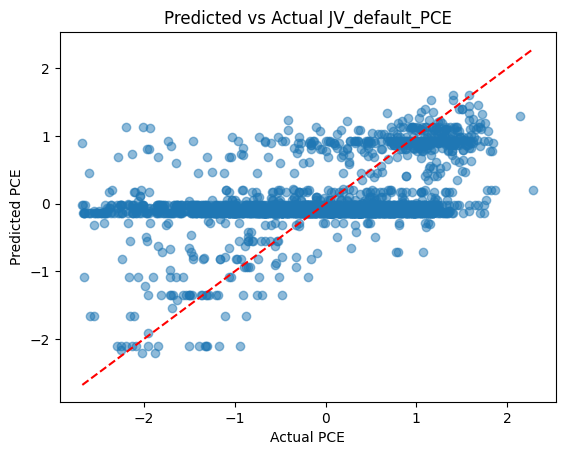

Mean Squared Error (MSE): 0.8203
R² Score: 0.2207


In [13]:
# Evaluation with actual predictions
import matplotlib.pyplot as plt

model.eval()
actuals = []
predictions = []

with torch.no_grad():
    for batch_X, batch_Y in test_loader:
        preds = model(batch_X).squeeze().numpy()  # Get predictions
        actual = batch_Y.squeeze().numpy()  # Get actual values
        
        predictions.extend(preds)  
        actuals.extend(actual)  

# Convert lists to numpy arrays
predictions = np.array(predictions)
actuals = np.array(actuals)

## plot comparison and find error/accuracy

plt.scatter(actuals, predictions, alpha=0.5)
plt.xlabel("Actual PCE")
plt.ylabel("Predicted PCE")
plt.title("Predicted vs Actual JV_default_PCE")
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red', linestyle='dashed')  # Ideal 1:1 line
plt.show()

from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Encoding the perovskite layers - K-NN CLUSTERING

In [ ]:
# Prepare for Transformer model: Define a custom embedding layer for materials

import torch
import torch.nn as nn

# Number of materials (including perovskite flattened vectors)
num_materials = len(material_to_id) + len(ions)  # Add ions for flattened perovskite vector
embedding_dim = 16  # Example embedding dimension

class MaterialEmbeddingLayer(nn.Module):
    def __init__(self, num_materials, embedding_dim):
        super(MaterialEmbeddingLayer, self).__init__()
        self.embeddings = nn.Embedding(num_materials, embedding_dim)
    
    def forward(self, x):
        return self.embeddings(x)

# Example usage
embedding_layer = MaterialEmbeddingLayer(num_materials, embedding_dim)

# Example input: Full stack vector (without flattening)
example_input = torch.tensor([material_to_id['Substrate1'], material_to_id['ETL1'], material_to_id['Pb'], material_to_id['HTL1'], material_to_id['Backcontact1']])

embedded_output = embedding_layer(example_input)

print("Embedded output:", embedded_output)


Visualiation of perovskite compositions

In [3]:
## clustering

from sklearn.cluster import KMeans

# # 11 short form comppositions = 11 clusters
# kmeans = KMeans(n_clusters=11, random_state=0)
# df['Cluster'] = kmeans.fit_predict(np.vstack(df['Perovskite_composition_vector']))

## visualise

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv(r'cleaned_data_for_generative.csv')

# Assuming 'df' has the perovskite compositions and t-SNE reduced vectors
tsne = TSNE(n_components=2, random_state=0)
reduced_vectors = tsne.fit_transform(np.vstack(df['Perovskite_composition_vector']))

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))  # Increase the figure size if needed
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=df['Cluster'], cmap='viridis')

# Add labels to each point
for i, txt in enumerate(df['Perovskite_composition_long_form']):
    plt.text(reduced_vectors[i, 0], reduced_vectors[i, 1], txt, fontsize=8, alpha=0.7)

# Customize the plot
plt.title('t-SNE Visualization of Perovskite Compositions')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar()  # Show colorbar for cluster
plt.show()

# from sklearn.metrics import silhouette_score

# # Get the silhouette score
# silhouette_avg = silhouette_score(np.vstack(df['Perovskite_composition_vector']), df['Cluster'])
# print(f'Silhouette Score: {silhouette_avg}')

# from sklearn.metrics import davies_bouldin_score

# # Get Davies-Bouldin score
# db_index = davies_bouldin_score(np.vstack(df['Perovskite_composition_vector']), df['Cluster'])
# print(f'Davies-Bouldin Index: {db_index}')


ValueError: could not convert string to float: '[1. 0. 1. 0. 0. 3.]'

### Simplifying the model - LSTM
This LSTM-based language model (built and trained using PyTorch) will be used to generate PSC cell stacks with varied amounts of randomness, sampling from materials in the different layers. It uses a language modelling approach to predict the next 'token' (material/layer) in each sequence, learning from existing cell stacks.

1. Creating the model (using unique integer IDs)

In [113]:
import pandas as pd
import torch
from torch.utils.data import Dataset

class PSCStackDataset(Dataset):
    def __init__(self, csv_file, column_name):
        self.data = pd.read_csv(csv_file)[column_name].dropna().tolist()
        self.data = [f"<SOS>,{seq},<EOS>" for seq in self.data]  # Ensure order and special tokens

        # Build vocab
        self.vocab, self.idx_to_stack = self.build_vocab(self.data)

        # Encode dataset
        self.encoded_data = [self.encode(seq) for seq in self.data]

        # 🔹 Store allowed materials per layer position
        self.allowed_per_position = self.get_allowed_per_position()

    def build_vocab(self, sequences):
        unique_tokens = set()
        for seq in sequences:
            unique_tokens.update(seq.split(','))  # Collect unique materials/tokens

        # Ensure special tokens are included
        unique_tokens.update(['<SOS>', '<EOS>'])

        # Create consistent index mappings
        stack_to_idx = {token: idx for idx, token in enumerate(sorted(unique_tokens))}
        idx_to_stack = {idx: token for token, idx in stack_to_idx.items()}

        return stack_to_idx, idx_to_stack

    def encode(self, sequence):
        return [self.vocab[token] for token in sequence.split(',')]

    def get_allowed_per_position(self):
        """Extracts unique materials at each layer position in the sequence."""
        allowed = {i: set() for i in range(7)}  # 7 positions: <SOS>, Substrate, ETL, Perovskite, HTL, Backcontact, <EOS>

        for seq in self.data:
            tokens = seq.split(',')
            if len(tokens) == 7:  # Ensure valid sequences
                for i, token in enumerate(tokens):
                    allowed[i].add(token)

        return {i: sorted(list(materials)) for i, materials in allowed.items()}

    def __len__(self):
        return len(self.encoded_data)

    def __getitem__(self, idx):
        seq = self.encoded_data[idx]
        return torch.tensor(seq[:-1], dtype=torch.long), torch.tensor(seq[1:], dtype=torch.long)  # Shifted for prediction

# 🔹 Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, x, hidden=None):
        x = self.embedding(x)
        output, hidden = self.lstm(x, hidden)
        output = self.fc(output)
        return output, hidden


# 🔹 Temperature sampling function
def sample_with_temperature(probs, temperature=1.0):
    probs = torch.pow(probs, 1.0 / temperature)
    probs /= torch.sum(probs)
    return torch.multinomial(probs, num_samples=1).item()


# 🔹 Hyperparameters
EMBED_SIZE = 128
HIDDEN_SIZE = 256
NUM_LAYERS = 2
BATCH_SIZE = 32
EPOCHS = 10
LR = 0.001

# 🔹 Load dataset
dataset = PSCStackDataset(csv_file='cleaned_data_for_generative.csv', column_name='Cleaned cell stack')
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# 🔹 Initialize model
model = LSTMModel(vocab_size=len(dataset.vocab), embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

print("Vocabulary size:", len(dataset.vocab))
print("Sample vocabulary items:", list(dataset.vocab.items())[:10])

Vocabulary size: 345
Sample vocabulary items: [(' Ag', 0), (' Al', 1), (' Au', 2), (' Carbon', 3), (' Cs0.017FA0.83MA0.15PbBr0.51I2.49', 4), (' Cs0.025FA0.81MA0.15PbBr0.45I2.5', 5), (' Cs0.025FA0.825MA0.15PbBr0.45I2.55', 6), (' Cs0.02FA0.79MA0.16PbBr0.551I2.49', 7), (' Cs0.02FA0.83MA0.17PbBr0.51I2.49', 8), (' Cs0.02FA0.95MA0.03PbBr0.09I2.91', 9)]


2. Train the model

In [114]:
# Training loop
device = torch.device("cpu")  # Keeping it on CPU
model.to(device)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs, _ = model(inputs)  # Forward pass

        # 🔹 Reshape output to match target
        loss = criterion(outputs.view(-1, len(dataset.vocab)), targets.view(-1))

        # 🔹 Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # 🔹 Optional: Print batch loss every N batches
        if batch_idx % 10 == 0:  # Change 10 to a suitable number
            print(f"Epoch [{epoch+1}/{EPOCHS}], Batch [{batch_idx}/{len(dataloader)}], Loss: {loss.item():.4f}")

    # 🔹 Print epoch loss
    print(f"Epoch [{epoch+1}/{EPOCHS}] Finished - Average Loss: {total_loss/len(dataloader):.4f}")

Epoch [1/10], Batch [0/340], Loss: 5.8634
Epoch [1/10], Batch [10/340], Loss: 2.9168
Epoch [1/10], Batch [20/340], Loss: 1.5966
Epoch [1/10], Batch [30/340], Loss: 1.3681
Epoch [1/10], Batch [40/340], Loss: 0.9122
Epoch [1/10], Batch [50/340], Loss: 0.6743
Epoch [1/10], Batch [60/340], Loss: 0.6134
Epoch [1/10], Batch [70/340], Loss: 0.7403
Epoch [1/10], Batch [80/340], Loss: 0.5617
Epoch [1/10], Batch [90/340], Loss: 0.5327
Epoch [1/10], Batch [100/340], Loss: 0.6226
Epoch [1/10], Batch [110/340], Loss: 0.5259
Epoch [1/10], Batch [120/340], Loss: 0.4303
Epoch [1/10], Batch [130/340], Loss: 0.4375
Epoch [1/10], Batch [140/340], Loss: 0.4806
Epoch [1/10], Batch [150/340], Loss: 0.4240
Epoch [1/10], Batch [160/340], Loss: 0.3572
Epoch [1/10], Batch [170/340], Loss: 0.3334
Epoch [1/10], Batch [180/340], Loss: 0.4598
Epoch [1/10], Batch [190/340], Loss: 0.5071
Epoch [1/10], Batch [200/340], Loss: 0.4540
Epoch [1/10], Batch [210/340], Loss: 0.3861
Epoch [1/10], Batch [220/340], Loss: 0.4927

3. Regularisation to encourage more meaningful embeddings/representations:

In [115]:
l2_lambda = 1e-5  # Adjust this to control embedding regularization strength
embedding_loss = l2_lambda * model.embedding.weight.norm(2)  # L2 Regularization

# Compute the main loss
loss = criterion(outputs.view(-1, len(dataset.vocab)), targets.view(-1)) + embedding_loss

4. Generate sequences:

In [116]:
import torch.nn.functional as F
import torch
import random

import torch

def generate_sequence(model, dataset, start_token='<SOS>', max_length=7, temperature=1.0):
    """
    Generates a valid perovskite solar cell stack sequence while ensuring layer constraints.
    """
    model.eval()
    
    # Start with <SOS> token
    generated_sequence = []
    
    # Convert words to indices
    input_seq = torch.tensor([dataset.vocab['<SOS>']], dtype=torch.long).unsqueeze(0)  # Shape: (1, 1)
    
    for position in range(1, max_length):  # Generate each layer position
        allowed_tokens = dataset.allowed_per_position[position]  # Get valid choices for this layer
        allowed_indices = [dataset.vocab[token] for token in allowed_tokens]  # Convert to vocab indices
        
        # Get model predictions
        with torch.no_grad():
            output, _ = model(input_seq)  # Unpack logits and hidden state
            logits = output[:, -1, :]  # Get logits for the last generated token

        logits = output[:, -1, :]  # Get logits for the last generated token

        # Apply temperature scaling
        logits = logits / temperature

        # Convert logits to probabilities
        probs = F.softmax(logits, dim=-1).squeeze()

        # # Debugging print statements
        # print(f"Logits: {logits}")
        # print(f"Probabilities: {probs}")

        # Check for NaN or negative values
        if torch.isnan(probs).any() or torch.isinf(probs).any():
            raise ValueError("Found NaN or Inf in probability tensor!")
        if (probs < 0).any():
            raise ValueError("Found negative probabilities!")

        # Sample next token
        next_idx = torch.multinomial(probs, num_samples=1).item()
        next_token = dataset.idx_to_stack[next_idx]

        generated_sequence.append(next_token)
        
        if next_token == '<EOS>':
            break  # Stop generation when <EOS> is reached
        
        # Append new token to input sequence
        input_seq = torch.cat([input_seq, torch.tensor([[next_idx]], dtype=torch.long)], dim=1)

    return ','.join(generated_sequence)

# 🔹 Generate sequences at different temperatures
temperatures = [0.5, 1.0, 1.5]

print("\nGenerated Sequences at Different Temperatures:")
for temp in temperatures:
    print(f"\nTemperature {temp}:")
    for i in range(3):  # Generate 3 sequences per temperature
        print(f"Sample {i+1}: {generate_sequence(model, dataset, start_token='<SOS>', max_length=7, temperature=temp)}")


Generated Sequences at Different Temperatures:

Temperature 0.5:
Sample 1: <SOS>,SLG|FTO, TiO2-c|TiO2-mp, MAPbI3, Spiro-MeOTAD, Au
Sample 2: <SOS>,SLG|FTO, TiO2-c|TiO2-mp, MAPbI3, Spiro-MeOTAD, Au
Sample 3: <SOS>,SLG|FTO, TiO2-c|TiO2-mp, MAPbI3, Spiro-MeOTAD, Au

Temperature 1.0:
Sample 1: <SOS>,SLG|FTO, TiO2-c|TiO2-mp, MAPbI3, Spiro-MeOTAD, Au
Sample 2: <SOS>,SLG|FTO, TiO2-c|TiO2-mp, MAPb1.0I3, Spiro-MeOTAD, Au
Sample 3: <SOS>,SLG|FTO, TiO2-c, MAPbI3, Spiro-MeOTAD, Au

Temperature 1.5:
Sample 1: <SOS>,SLG|FTO, TiO2-c, MAPbI3, Spiro-MeOTAD, Ag
Sample 2: <SOS>,SLG|FTO, TiO2-c|TiO2-mp, MAPbI3, Spiro-MeOTAD, Ag
Sample 3: <SOS>,SLG|FTO, TiO2-c, MAPbBr0.3I2.7, Spiro-MeOTAD, Au


### Regression models to predict PCE and stability of generated stacks

1. Load and create embeddings, then convert the dataset

In [117]:
import torch

# 📌 Get the embedding matrix from the trained LSTM model
embedding_layer = model.embedding  # Assuming your LSTM model has an embedding layer
embedding_matrix = embedding_layer.weight.detach().cpu().numpy()  # Convert to NumPy

import numpy as np

def stack_to_vector(stack, dataset, embedding_matrix, method="mean"):
    """
    Converts a cleaned cell stack sequence into a numerical vector.
    
    Args:
        stack (str): Stack sequence (comma-separated materials).
        dataset: Dataset object containing vocab mappings.
        embedding_matrix (numpy.array): Pretrained material embeddings.
        method (str): How to combine material embeddings. Options: "mean", "concat".
        
    Returns:
        numpy.array: Vector representation of the stack.
    """
    tokens = stack.split(',')
    token_indices = [dataset.vocab[token] for token in tokens if token in dataset.vocab]
    
    if not token_indices:  # In case no valid tokens are found
        return np.zeros(embedding_matrix.shape[1])  # Return a zero vector
    
    embeddings = embedding_matrix[token_indices]  # Fetch embeddings

    if method == "mean":
        return np.mean(embeddings, axis=0)  # Average pooling (good for variable-length stacks)
    elif method == "concat":
        # Ensure fixed length: Pad with zeros if needed
        max_layers = 5  # Adjust based on your max stack size
        padded_embeddings = np.zeros((max_layers, embedding_matrix.shape[1]))
        for i, emb in enumerate(embeddings[:max_layers]):
            padded_embeddings[i] = emb
        return padded_embeddings.flatten()  # Concatenate embeddings
    else:
        raise ValueError("Invalid method. Use 'mean' or 'concat'.")

# Convert entire dataset into vectors
X = np.array([stack_to_vector(stack, dataset, embedding_matrix) for stack in df['Cleaned cell stack']])


2. Train the models

In [119]:
y_pce = df['JV_default_PCE'].values
y_stability = df['Stability_PCE_end_of_experiment'].values

# Train XGBoost models or any other regression model
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train_pce, y_test_pce = train_test_split(X, y_pce, test_size=0.2, random_state=42)

pce_model = XGBRegressor()
pce_model.fit(X_train, y_train_pce)

stability_model = XGBRegressor()
stability_model.fit(X_train, y_stability)

# Predict on generated stacks
generated_stacks = ["SLG|FTO, TiO2-c|TiO2-mp, MAPbI3, Spiro-MeOTAD, Au", "SLG|FTO, TiO2-c, MAPbI3, Spiro-MeOTAD, Au"]  # Replace with real generated stacks
generated_vectors = np.array([stack_to_vector(stack, dataset, embedding_matrix) for stack in generated_stacks])

pred_pce = pce_model.predict(generated_vectors)
pred_stability = stability_model.predict(generated_vectors)

for stack, pce, stability in zip(generated_stacks, pred_pce, pred_stability):
    print(f"Stack: {stack} -> Predicted JV_default_PCE: {pce:.2f}, Stability_PCE_end_of_experiment: {stability:.2f}")


XGBoostError: [16:47:59] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\data\data.cc:514: Check failed: valid: Label contains NaN, infinity or a value too large.

VISUALISE EMBEDDINGS??

Embeddings shape: (13, 128)
First few embeddings:
 [[-2.12812948e+00 -1.46260953e+00  2.55295664e-01 -7.41778314e-01
  -6.21434569e-01 -3.27618629e-01 -1.31295228e+00  9.26068187e-01
   1.18227434e+00 -1.25475943e+00  1.94211292e+00  9.22257841e-01
  -4.05723214e-01 -1.68785334e+00  9.60368395e-01  9.68457982e-02
  -7.38985121e-01 -1.67304230e+00  2.68288636e+00  9.48630869e-01
  -1.29269040e+00 -6.68708682e-01  6.19766265e-02 -8.50536227e-01
  -4.81636673e-01 -1.65542826e-01 -1.03301907e+00 -1.44052839e+00
   4.39153254e-01 -1.19351991e-01 -2.40408921e+00 -6.97402537e-01
  -2.25648379e+00  2.03859344e-01  1.26301360e+00  9.33275044e-01
   4.08805460e-02  3.02648038e-01  2.38105226e+00 -2.10164770e-01
   9.93197143e-01 -4.58247066e-01  6.86937153e-01  1.50740385e-01
   6.17566526e-01 -7.07163811e-01 -1.30705297e+00  5.85805595e-01
   4.19562608e-02  2.13043258e-01 -7.47326195e-01 -6.94754183e-01
   2.71665245e-01  4.89660770e-01 -1.59093428e+00  9.86897051e-02
   6.58556998e-01 -5.0527

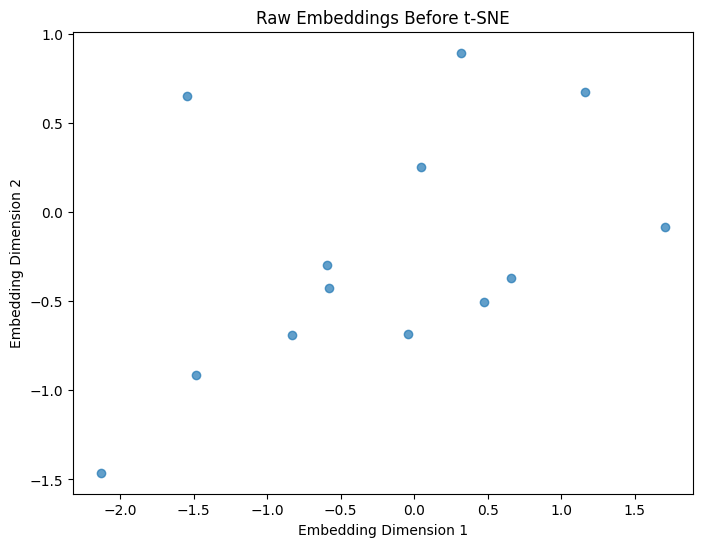

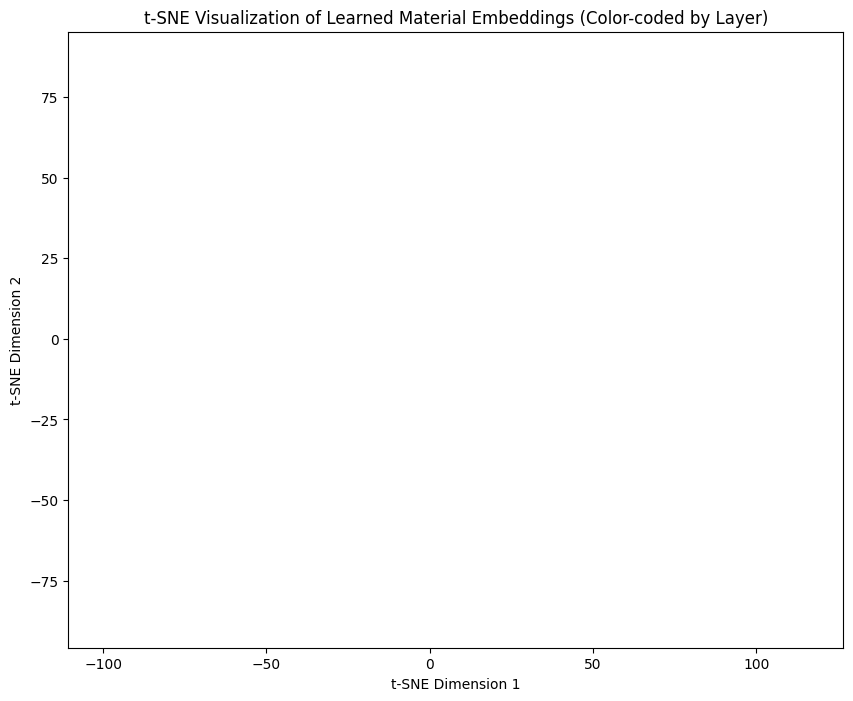

In [48]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Define layer colors
layer_colors = {
    "Substrate": "red",
    "ETL": "blue",
    "Perovskite": "green",
    "HTL": "purple",
    "Backcontact": "orange"
}

# Load dataset to assign materials to layers
df = pd.read_csv("cleaned_data_for_generative.csv")

# Map materials to their respective layers
material_to_layer = {}
for col, layer in zip(
    ["Substrate_stack_sequence", "ETL_stack_sequence", "Perovskite_composition_long_form",
     "HTL_stack_sequence", "Backcontact_stack_sequence"],
    ["Substrate", "ETL", "Perovskite", "HTL", "Backcontact"]
):
    for materials in df[col].dropna().tolist():
        for material in materials.split('|'):  # Handle multi-material layers
            material_to_layer[material] = layer

# Extract learned embeddings
embeddings = model.embedding.weight.detach().cpu().numpy()

# Check if embeddings are valid
print("Embeddings shape:", embeddings.shape)
print("First few embeddings:\n", embeddings[:5])

# Normalize embeddings before t-SNE to prevent scale issues
scaler = StandardScaler()
embeddings_normalized = scaler.fit_transform(embeddings)

# Reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, len(embeddings)-1))
reduced_embeddings = tsne.fit_transform(embeddings_normalized)

# Verify t-SNE output
print("Reduced embeddings shape:", reduced_embeddings.shape)
print("First few reduced embeddings:\n", reduced_embeddings[:5])

# Check min/max values to adjust plot limits if necessary
print("X min/max:", reduced_embeddings[:, 0].min(), reduced_embeddings[:, 0].max())
print("Y min/max:", reduced_embeddings[:, 1].min(), reduced_embeddings[:, 1].max())

# Get colors for each material
vocab_tokens = list(dataset.vocab.keys())  # List of materials in vocabulary
colors = [layer_colors.get(material_to_layer.get(token, "black")) for token in vocab_tokens]  # Default to black if unknown

# Plot raw embeddings before t-SNE to check distribution
plt.figure(figsize=(8, 6))
plt.scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.7)
plt.title("Raw Embeddings Before t-SNE")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.show()

# Normalize t-SNE output if values are extreme
if abs(reduced_embeddings).max() > 1000:
    reduced_embeddings /= np.max(np.abs(reduced_embeddings))  # Normalize to [-1, 1]

# Final t-SNE plot
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=colors, alpha=0.7, edgecolors="k")
plt.xlim(reduced_embeddings[:, 0].min() - 1, reduced_embeddings[:, 0].max() + 1)
plt.ylim(reduced_embeddings[:, 1].min() - 1, reduced_embeddings[:, 1].max() + 1)
plt.title("t-SNE Visualization of Learned Material Embeddings (Color-coded by Layer)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


VERSION 2

Preprocessing:

In [64]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

# Load data
df = pd.read_csv("cleaned_data_for_generative.csv")
sequences = df["Cleaned cell stack"].astype(str).tolist()  # Ensure strings

# Extract unique sequences (entire stack as a token)
unique_stacks = sorted(set(sequences))
stack_to_idx = {stack: idx for idx, stack in enumerate(unique_stacks)}
idx_to_stack = {idx: stack for stack, idx in stack_to_idx.items()}

# Convert to integer sequences
encoded_sequences = [stack_to_idx[seq] for seq in sequences]

Define the model

In [68]:
class StackDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        return torch.tensor(seq, dtype=torch.long)

# Hyperparameters
EMBED_DIM = 128
HIDDEN_DIM = 256
NUM_LAYERS = 2
BATCH_SIZE = 32
EPOCHS = 10
VOCAB_SIZE = len(unique_stacks)

# Dataloader
dataset = StackDataset(encoded_sequences)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Define LSTM model
class LSTMGenerator(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers):
        super(LSTMGenerator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        x, hidden = self.lstm(x, hidden)
        x = self.fc(x)
        return x, hidden

# Initialize model
model = LSTMGenerator(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Train the model:

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(EPOCHS):
    total_loss = 0
    for batch in dataloader:
        batch = batch.to(device)

        if batch.dim() == 1:  # Ensure batch is 2D
            batch = batch.unsqueeze(0)

        optimizer.zero_grad()

        inputs = batch[:, :-1]  # All except last token
        targets = batch[:, 1:]  # Shifted by 1 position

        outputs, _ = model(inputs)
        loss = criterion(outputs.view(-1, VOCAB_SIZE), targets.view(-1))
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(dataloader)}")


Epoch 1/10, Loss: 3.3646128864849314
Epoch 2/10, Loss: 3.2023274232359493
Epoch 3/10, Loss: 3.1891120630152083
Epoch 4/10, Loss: 3.195507690485786
Epoch 5/10, Loss: 3.1927916667040654
Epoch 6/10, Loss: 3.1891258737620185
Epoch 7/10, Loss: 3.1891892811831304
Epoch 8/10, Loss: 3.1864127958522124
Epoch 9/10, Loss: 3.1826281224980075
Epoch 10/10, Loss: 3.184621625437456


Generating stacks:

In [71]:
import random

def generate_stack(model, temperature=1.0, max_len=6):
    model.eval()
    generated = ["<SOS>"]
    hidden = None

    while len(generated) < max_len:
        input_seq = torch.tensor([stack_to_idx[generated[-1]]]).unsqueeze(0).to(device)
        output, hidden = model(input_seq, hidden)
        
        # Apply temperature scaling
        output = output.squeeze().div(temperature).exp()
        probs = output / output.sum()
        
        next_idx = torch.multinomial(probs, 1).item()
        next_token = idx_to_stack[next_idx]

        if next_token == "<EOS>":
            break

        generated.append(next_token)

    return ",".join(generated + ["<EOS>"])

# Generate samples at different temperatures
for temp in [0.5, 1.0, 1.5]:
    print(f"\nTemperature {temp}:")
    for _ in range(3):
        print(generate_stack(model, temperature=temp))



Temperature 0.5:


KeyError: '<SOS>'

In [72]:
print("<SOS>" in stack_to_idx)  # Should return True
print(stack_to_idx.keys())  # Print all available keys


False
dict_keys(['<SOS>,SLG|FTO, TiO2-c, Cs0.017FA0.83MA0.15PbBr0.51I2.49, Spiro-MeOTAD, Ag,<EOS>', '<SOS>,SLG|FTO, TiO2-c, Cs0.025FA0.81MA0.15PbBr0.45I2.5, Spiro-MeOTAD, Au,<EOS>', '<SOS>,SLG|FTO, TiO2-c, Cs0.02FA0.79MA0.16PbBr0.551I2.49, Spiro-MeOTAD, Au,<EOS>', '<SOS>,SLG|FTO, TiO2-c, Cs0.02FA0.83MA0.17PbBr0.51I2.49, Spiro-MeOTAD, Au,<EOS>', '<SOS>,SLG|FTO, TiO2-c, Cs0.03FA0.97PbI3, Spiro-MeOTAD, Au,<EOS>', '<SOS>,SLG|FTO, TiO2-c, Cs0.05FA0.75MA0.2PbBr0.3I2.7, Spiro-MeOTAD, Au,<EOS>', '<SOS>,SLG|FTO, TiO2-c, Cs0.05FA0.7885MA0.1615PbBr0.51I2.49, Spiro-MeOTAD, Au,<EOS>', '<SOS>,SLG|FTO, TiO2-c, Cs0.05FA0.7885MA0.1625PbBr0.45I2.55, Spiro-MeOTAD, Au,<EOS>', '<SOS>,SLG|FTO, TiO2-c, Cs0.05FA0.788MA0.162PbBr0.51I2.49, Spiro-MeOTAD, Au,<EOS>', '<SOS>,SLG|FTO, TiO2-c, Cs0.05FA0.79MA0.15PbBr0.51I2.49, Spiro-MeOTAD, Au,<EOS>', '<SOS>,SLG|FTO, TiO2-c, Cs0.05FA0.79MA0.16PbBr0.3I2.7, Spiro-MeOTAD, Au,<EOS>', '<SOS>,SLG|FTO, TiO2-c, Cs0.05FA0.79MA0.16PbBr0.45I2.55, Spiro-MeOTAD, Au,<EOS>', '<SOS>,